<a href="https://colab.research.google.com/github/victor22-gif/Internet-usage-Analysis-/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--2025-01-28 11:23:20--  https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 970457 (948K) [text/plain]
Saving to: ‘Telco-Customer-Churn.csv.5’

Telco-Customer-Chur 100%[===================>] 947.71K  --.-KB/s    in 0.04s   

2025-01-28 11:23:20 (21.8 MB/s) - ‘Telco-Customer-Churn.csv.5’ saved [970457/970457]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.65      0.47      0.55       373

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



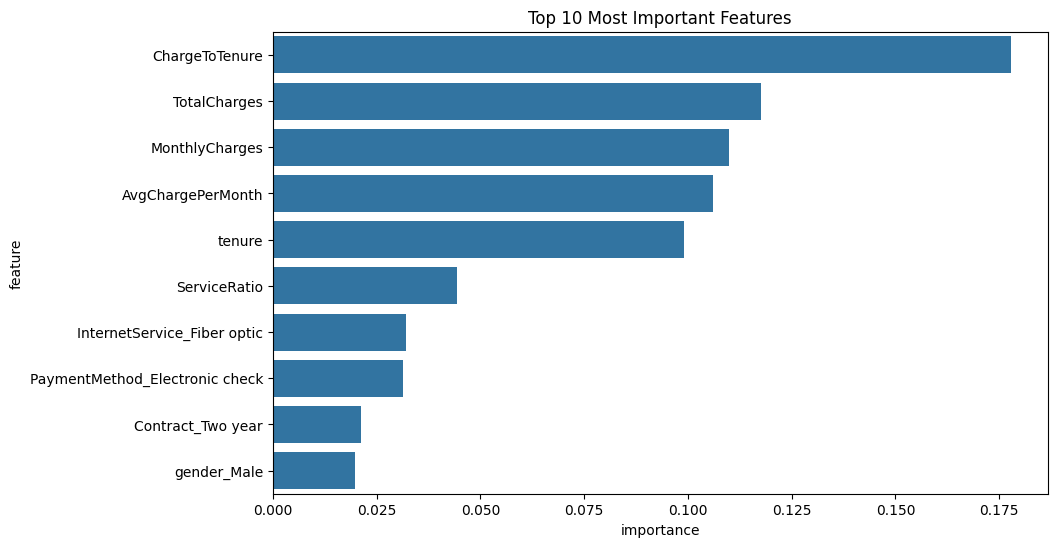

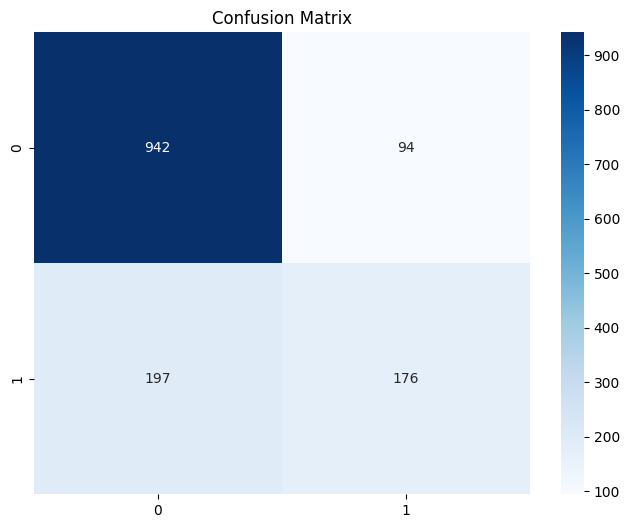


Churn Predictions for New Customers:
customerID  Churn_Probability
   CUST123               0.33
   CUST124               0.04


In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepare the data
!wget https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

# Read the data
df = pd.read_csv('Telco-Customer-Churn.csv')

def clean_data(df):
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()

    # Convert TotalCharges to numeric
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # Fill missing values in TotalCharges - avoiding inplace
    df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'])

    # Get list of categorical columns (excluding customerID and target variable)
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    categorical_cols.remove('customerID')
    categorical_cols.remove('Churn')

    # Create dummy variables for all categorical columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Convert target variable last
    df['Churn'] = (df['Churn'] == 'Yes').astype(int)

    return df

# Clean the data
df_cleaned = clean_data(df)

def engineer_features(df):
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()

    # Calculate average charge per month
    df['AvgChargePerMonth'] = df['TotalCharges'] / (df['tenure'] + 1)

    # Create total services ratio (compared to possible services)
    service_columns = [col for col in df.columns if col.endswith('_Yes')]
    df['ServiceRatio'] = df[service_columns].sum(axis=1) / len(service_columns)

    # Create interaction features
    df['ChargeToTenure'] = df['MonthlyCharges'] / (df['tenure'] + 1)

    return df

# Engineer features
df_final = engineer_features(df_cleaned)

# Prepare features for modeling
X = df_final.drop(['Churn', 'customerID'], axis=1)
y = df_final['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

def evaluate_model(y_true, y_pred, X):
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Feature importance plot
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Most Important Features')
    plt.show()


    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

# display plots
evaluate_model(y_test, y_pred, X)

# Example usage with new customers
def predict_churn(customer_data):
    """
    Make predictions for new customers
    Parameters:
        customer_data: DataFrame containing customer information in the same format as the original dataset
    Returns:
        Probability of churn for each customer
    """
    # Clean and prepare the data
    customer_cleaned = clean_data(customer_data)
    customer_features = engineer_features(customer_cleaned)
    customer_features = customer_features.drop(['Churn', 'customerID'], axis=1)

    # Ensure columns match training data
    missing_cols = set(X.columns) - set(customer_features.columns)
    for col in missing_cols:
        customer_features[col] = 0
    customer_features = customer_features[X.columns]

    # Scale the features
    customer_scaled = scaler.transform(customer_features)

    # Make prediction
    prediction = model.predict_proba(customer_scaled)
    return prediction[:, 1]  # Return probability of churn

# Example of using predict_churn
new_customers = pd.DataFrame({
    'customerID': ['CUST123', 'CUST124'],
    'gender': ['Female', 'Male'],
    'InternetService': ['Fiber optic', 'DSL'],
    'Contract': ['Month-to-month', 'Two year'],
    'PaymentMethod': ['Electronic check', 'Credit card (automatic)'],
    'tenure': [12, 24],
    'MonthlyCharges': [80.0, 65.0],
    'TotalCharges': [960.0, 1560.0],
    'PhoneService': ['Yes', 'Yes'],
    'OnlineBackup': ['No', 'Yes'],
    'DeviceProtection': ['Yes', 'No'],
    'TechSupport': ['No', 'Yes'],
    'Churn': ['No', 'No']
})

# Get predictions
churn_probabilities = predict_churn(new_customers)

# Create readable output
results = pd.DataFrame({
    'customerID': new_customers['customerID'],
    'Churn_Probability': churn_probabilities
})

print("\nChurn Predictions for New Customers:")
print(results.to_string(index=False))